## Classification of one mouse

This notebook is used to classify the data of one mouse. The mouse used is 05604 of breed bxd_056. The third day of the experiment is used. 80% of the data will be used to do the training.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import sys
sys.path.append('../Library')

import breedManip as breedManip
import dataProcessing as dataProcessing
import breeds as breeds
import splitData as splitData

import importlib
importlib.reload(splitData)

<module 'splitData' from '/mnt/remote/workspaces/magali.egger/TBproject/Travail_Bachelor/ClassificationSimple/../Library/splitData.py'>

#### Preparation of the data

In [14]:
with open('/home/magali.egger/workspace/TBproject/Travail_Bachelor/Data/df_simplify_day3.pkl', 'rb') as f:
    df = pickle.load(f)

In [15]:
df[df['mouse'] == '05604']

,Unnamed: 0,rawState,state,EEGv,EMGv,epoch,day,spectral_flatness,spectral_centroid,spectral_entropy,...,EMGv_max100,EEGv_log,EMGv_log,bias,EEGv^2,EEGv^3,EMGv^2,EMGv^3,mouse,breed
42193,43200,n,n,1.204878e-08,1.015461e-10,43200,2,0.021553,4.758978,-4.924338,...,8.671615e-09,-18.234303,-23.010508,1,1.451730e-16,1.749157e-24,1.031161e-20,1.047103e-30,05604,bxd_056
42194,43201,n,n,1.351429e-08,1.206824e-10,43201,2,0.033812,6.263104,-5.249444,...,8.671615e-09,-18.119518,-22.837859,1,1.826361e-16,2.468198e-24,1.456425e-20,1.757649e-30,05604,bxd_056
42195,43202,n,n,1.255891e-08,1.239595e-10,43202,2,0.032773,7.272192,-5.612604,...,8.671615e-09,-18.192836,-22.811066,1,1.577262e-16,1.980868e-24,1.536595e-20,1.904756e-30,05604,bxd_056
42196,43203,n,n,9.086000e-09,8.003900e-11,43203,2,0.036717,7.666186,-5.628821,...,8.671615e-09,-18.516531,-23.248507,1,8.255540e-17,7.500983e-25,6.406242e-21,5.127492e-31,05604,bxd_056
42197,43204,w,w,1.000401e-08,1.128837e-10,43204,2,0.036758,7.251899,-5.518506,...,8.671615e-09,-18.420279,-22.904663,1,1.000803e-16,1.001205e-24,1.274272e-20,1.438446e-30,05604,bxd_056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63191,64795,w,w,3.495622e-09,5.661560e-10,64795,2,0.172151,21.481729,-6.909614,...,1.267435e-08,-19.471754,-21.292151,1,1.221938e-17,4.271433e-26,3.205326e-19,1.814715e-28,05604,bxd_056
63192,64796,w,w,4.471170e-09,4.524093e-10,64796,2,0.129463,18.046184,-6.763685,...,1.267435e-08,-19.225616,-21.516434,1,1.999136e-17,8.938477e-26,2.046741e-19,9.259647e-29,05604,bxd_056
63193,64797,w,w,3.554805e-09,6.299265e-10,64797,2,0.135760,19.871331,-6.869086,...,1.267435e-08,-19.454966,-21.185418,1,1.263664e-17,4.492079e-26,3.968074e-19,2.499595e-28,05604,bxd_056
63194,64798,w,w,4.239275e-09,2.969832e-10,64798,2,0.109922,14.829857,-6.318693,...,1.267435e-08,-19.278874,-21.937345,1,1.797145e-17,7.618593e-26,8.819904e-20,2.619364e-29,05604,bxd_056


In [6]:
def split(df, seed):
    # Take random 20% of the data for testing the rest for the test
    df_test = df.sample(frac=0.2, random_state=seed)
    df_train = df.drop(df_test.index)
    return df_train, df_test

In [16]:
# take random 1728 number out of 86400
test_index = np.random.choice(86400, 1728, replace=False)

df_test = df.iloc[test_index]
df_train = df.drop(df_test.index)

In [ ]:
#df_test = df.sample(frac=0.2, random_state=42).copy()
#df_train = df.drop(df_test.index).copy()

In [ ]:
# df_train, df_test = split(df, 42)

In [18]:
df_train = df_train.drop(['mouse'], axis=1)
df_test = df_test.drop(['mouse'], axis=1)
df_train = df_train.drop(['breed'], axis=1)
df_test = df_test.drop(['breed'], axis=1)

In [19]:
x_train, x_test, y_train, y_test, le = splitData.encode_scale_data(df_train, df_test, 13, cat_matrix=True)

#### Training of the model

In [20]:
rfc = RandomForestClassifier(random_state=13, class_weight="balanced", n_jobs=-1)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

[[636   5  20]
 [ 15  64   7]
 [ 26   2 953]]
              precision    recall  f1-score   support

           n       0.94      0.96      0.95       661
           r       0.90      0.74      0.82        86
           w       0.97      0.97      0.97       981

    accuracy                           0.96      1728
   macro avg       0.94      0.89      0.91      1728
weighted avg       0.96      0.96      0.96      1728



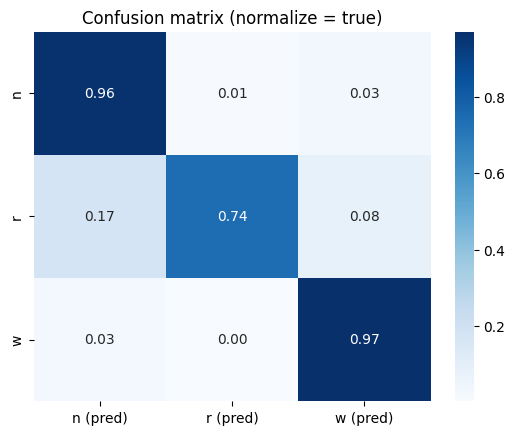

In [21]:
pred = np.argmax(y_pred, axis=1)
test = np.argmax(y_test, axis=1)

# plot the confusion matrix between predictions of the model and real values

cm = np.array(confusion_matrix(test, pred))
print(cm)

cm = np.array(confusion_matrix(test, pred, normalize='true')) # normalize = 'true' or 'pred'
confusion = pd.DataFrame(cm, index=le.classes_, columns=le.classes_ + ' (pred)')

print(classification_report(test, pred, target_names=le.classes_, zero_division=0))

sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true)')
plt.show()